<a href="https://www.kaggle.com/code/hkafrawi/mobile-a-b-testing?scriptVersionId=120644532" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
%matplotlib inline 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mobile-games-ab-testing/cookie_cats.csv


# Load and Explore the Dataset

In [2]:
df = pd.read_csv("/kaggle/input/mobile-games-ab-testing/cookie_cats.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
df['sum_gamerounds'].min(),df['sum_gamerounds'].max()

(0, 49854)

In [5]:
df['sum_gamerounds'].median()

16.0

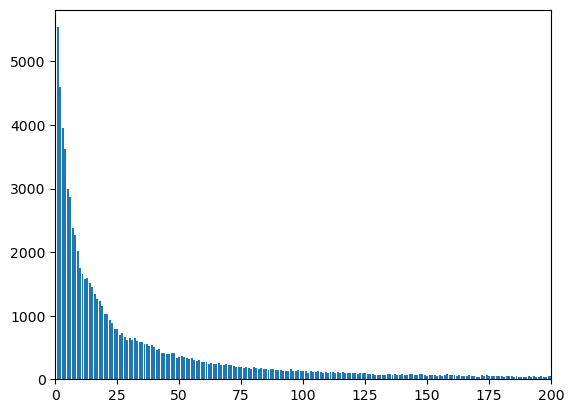

In [6]:
count_gamerounds = df.groupby('sum_gamerounds').size()
plt.bar(x=count_gamerounds.index,
       height=count_gamerounds.values)
plt.xlim(0,200)
plt.show()

In [7]:
df['version'].unique()

array(['gate_30', 'gate_40'], dtype=object)

In [8]:
df[df.duplicated()] #no duplicated enteries available

,userid,version,sum_gamerounds,retention_1,retention_7


In [9]:
df['userid'].nunique()

90189

In [10]:
df['sum_gamerounds'] = df['sum_gamerounds'].astype('int32') #downcasting datatype for preformance
df['version'] = df['version'].astype('category') #changing to category 
df2 = df.set_index('userid')

In [11]:
df2.info() # memory usage went from 2.2mb to 1.3mb

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90189 entries, 116 to 9999861
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   version         90189 non-null  category
 1   sum_gamerounds  90189 non-null  int32   
 2   retention_1     90189 non-null  bool    
 3   retention_7     90189 non-null  bool    
dtypes: bool(2), category(1), int32(1)
memory usage: 1.3 MB


# A/B Testing Retention 1 day

$$H_0: \mu_{gate30} - \mu_{gate40} = 0$$

$$H_1: \mu_{gate30} - \mu_{gate40} \neq 0$$


In [12]:
df2.query("version == 'gate_30'")['retention_1'].mean(),df2.query("version == 'gate_40'")['retention_1'].mean() 

(0.4481879194630872, 0.44228274967574577)

In [13]:
# calculate obs diff
gate_30_ret = df2.query("version == 'gate_30'")['retention_1']
gate_40_ret = df2.query("version == 'gate_40'")['retention_1']
obs_diff = gate_30_ret.mean() - gate_40_ret.mean()
obs_diff

0.005905169787341458

In [14]:
n_gate_30 = df2.query("version == 'gate_30'")['version'].count()
n_gate_40 = df2.query("version == 'gate_40'")['version'].count()

In [15]:
n_gate_30, n_gate_40

(44700, 45489)

In [16]:
p_diffs = []
size = df2.shape[0]
for _ in range(10_000):
    sample_df = df2.sample(size, replace=True)
    p_gate_30 = sample_df.query("version == 'gate_30'")['retention_1'].mean()
    p_gate_40 = sample_df.query("version == 'gate_40'")['retention_1'].mean()
    p_diffs.append(p_gate_30-p_gate_40)

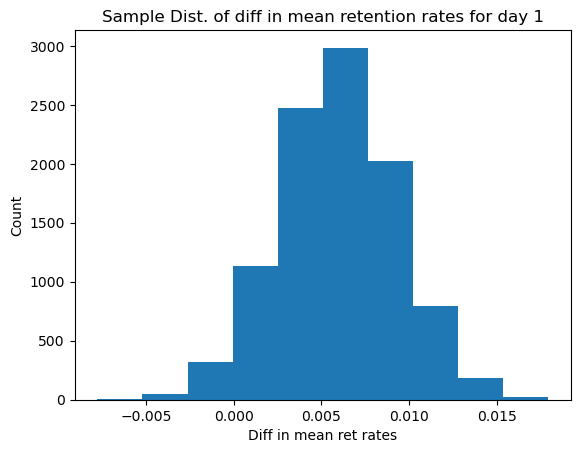

In [17]:
plt.hist(p_diffs)
plt.title("Sample Dist. of diff in mean retention rates for day 1")
plt.xlabel("Diff in mean ret rates")
plt.ylabel("Count")
plt.show()

In [18]:
null_vals = np.random.normal(0,np.array(p_diffs).std(),len(p_diffs))

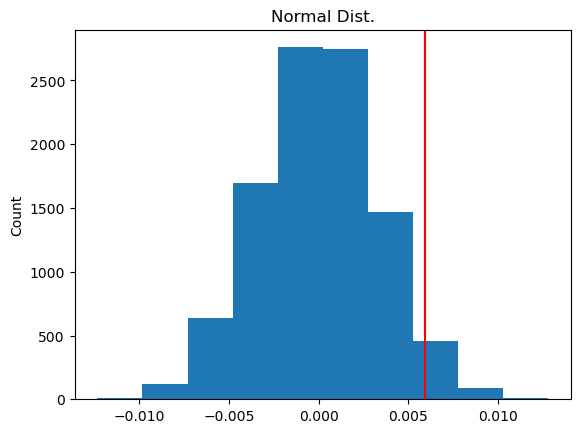

In [19]:
plt.hist(null_vals)
plt.title("Normal Dist.")
plt.ylabel("Count")
plt.axvline(x=obs_diff, color="r")
plt.show()

In [20]:
(null_vals>obs_diff).mean()

0.0352

### Conclusion A/B Testing Day 1 Retention Rates

We fail to reject $H_0$ and we are 95% confident that the gate_40 version's day 1 retention rate is not significantly different than gate_30 version's day 1 retention rate.

# A/B Testing 7 day Retention

$$H_0: \mu_{gate30} - \mu_{gate40} = 0$$

$$H_1: \mu_{gate30} - \mu_{gate40} \neq 0$$

In [21]:
# calculate obs diff
g30_ret_7 = df2.query("version == 'gate_30'")['retention_7'].mean()
g40_ret_7 = df2.query("version == 'gate_40'")['retention_7'].mean()
obs_diff = g30_ret_7 - g40_ret_7
obs_diff

0.008201298315205913

In [22]:
# n values will not change for this experiment
n_gate_30, n_gate_40

(44700, 45489)

In [23]:
p_diffss = []
size = df2.shape[0]
for _ in range(10_000):
    sampledf = df2.sample(size,replace=True)
    s_g30 = sampledf.query("version == 'gate_30'")['retention_7'].mean()
    s_g40 = sampledf.query("version == 'gate_40'")['retention_7'].mean()
    p_diffss.append(s_g30-s_g40)

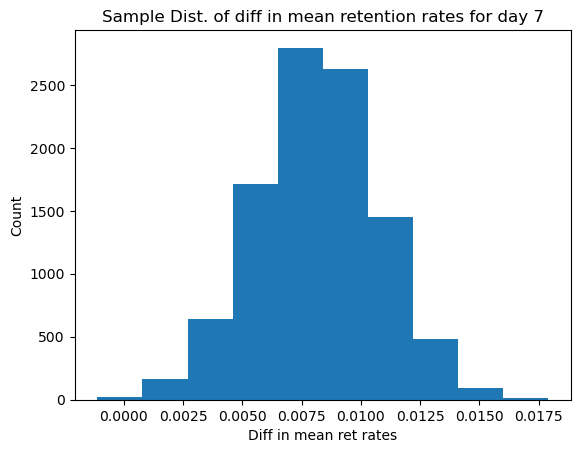

In [24]:
plt.hist(p_diffss)
plt.title("Sample Dist. of diff in mean retention rates for day 7")
plt.xlabel("Diff in mean ret rates")
plt.ylabel("Count")
plt.show()

In [25]:
null_vals = np.random.normal(0,np.array(p_diffss).std(),len(p_diffss))

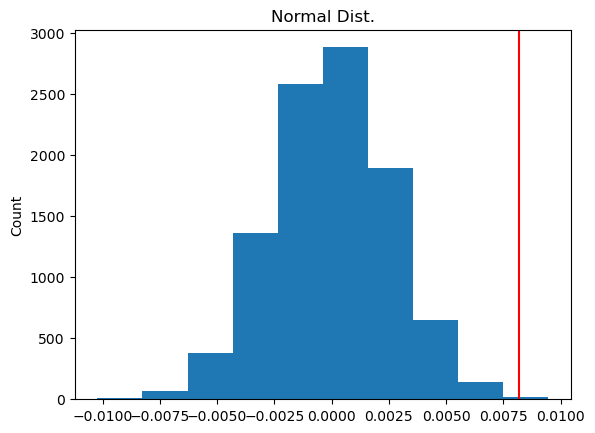

In [26]:
plt.hist(null_vals)
plt.title("Normal Dist.")
plt.ylabel("Count")
plt.axvline(x=obs_diff, color="r")
plt.show()

In [27]:
(null_vals>obs_diff).mean()

0.001

### Conclusion A/B Testing Day 7 Retention Rates
We reject $H_0$ and we are 95% confident that the gate_40 version's day 7 retention rate is significantly different than gate_30 version's day 7 retention rate.

# Regression Analysis
### Using Logistic Regression

In [28]:
# importing necessary libraries 
import statsmodels.api as sm

In [29]:
# add intercept
df2['intercept'] = 1

In [30]:
df3 = df2.drop('retention_1',axis=1) #droping unnecessary column

In [31]:
df3[['ret_7_False','ret_7_True']] = pd.get_dummies(df3['retention_7']) #add dummy variables for day 7 retention 

In [32]:
df3[['gate_30_version','gate_40_version']] = pd.get_dummies(df3['version'])

In [33]:
#Running Logit Regression Model
logit_mod = sm.Logit(df3['ret_7_True'],df3[['intercept','sum_gamerounds','gate_40_version']])
results = logit_mod.fit()
print(results.summary2())


Optimization terminated successfully.
         Current function value: 465.902845
         Iterations 8


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                           Results: Logit
Model:              Logit            Pseudo R-squared: inf          
Dependent Variable: ret_7_True       AIC:              84038629.2864
Date:               2023-02-28 18:41 BIC:              84038657.5153
No. Observations:   90189            Log-Likelihood:   -4.2019e+07  
Df Model:           2                LL-Null:          0.0000       
Df Residuals:       90186            LLR p-value:      1.0000       
Converged:          1.0000           Scale:            1.0000       
No. Iterations:     8.0000                                          
--------------------------------------------------------------------
                    Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
intercept          -2.6932   0.0182 -147.9627 0.0000 -2.7289 -2.6575
sum_gamerounds      0.0209   0.0002  114.8432 0.0000  0.0205  0.0212
gate_40_version    -0.0833   0.0214   -3.8885 0.0001 -0.1253 

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


In [34]:
print(f"intercept coff: {np.exp(-2.6932):.2f}")
print(f"sum_gamerounds coff: {np.exp(0.0209):.2f}")
print(f"gate_40_version coff: {np.exp(-0.0833):.2f}")

intercept coff: 0.07
sum_gamerounds coff: 1.02
gate_40_version coff: 0.92


In [35]:
#Running Logit Regression Model with only gate_40_version
logit_mod2 = sm.Logit(df3['ret_7_True'],df3[['intercept','gate_40_version']])
results = logit_mod2.fit()
print(results.summary2())

Optimization terminated successfully.
         Current function value: 306.693360
         Iterations 5


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                           Results: Logit
Model:              Logit            Pseudo R-squared: inf          
Dependent Variable: ret_7_True       AIC:              55320738.8190
Date:               2023-02-28 18:41 BIC:              55320757.6384
No. Observations:   90189            Log-Likelihood:   -2.7660e+07  
Df Model:           1                LL-Null:          0.0000       
Df Residuals:       90187            LLR p-value:      1.0000       
Converged:          1.0000           Scale:            1.0000       
No. Iterations:     5.0000                                          
--------------------------------------------------------------------
                    Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
intercept          -1.4487   0.0121 -120.2066 0.0000 -1.4723 -1.4251
gate_40_version    -0.0542   0.0171   -3.1641 0.0016 -0.0877 -0.0206



/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


In [36]:
print(f"intercept coff: {np.exp(-1.4487):.2f}")
print(f"gate_40_version coff: {np.exp(-0.0542):.2f}")

intercept coff: 0.23
gate_40_version coff: 0.95


In [37]:
#Running Logit Regression Model with only sum_gamerounds
logit_mod3 = sm.Logit(df3['ret_7_True'],df3[['intercept','sum_gamerounds']])
results = logit_mod3.fit()
print(results.summary2())

Optimization terminated successfully.
         Current function value: 465.702399
         Iterations 8


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                           Results: Logit
Model:              Logit            Pseudo R-squared: inf          
Dependent Variable: ret_7_True       AIC:              84002471.3054
Date:               2023-02-28 18:41 BIC:              84002490.1247
No. Observations:   90189            Log-Likelihood:   -4.2001e+07  
Df Model:           1                LL-Null:          0.0000       
Df Residuals:       90187            LLR p-value:      1.0000       
Converged:          1.0000           Scale:            1.0000       
No. Iterations:     8.0000                                          
--------------------------------------------------------------------
                    Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
intercept          -2.7343   0.0150 -182.6261 0.0000 -2.7636 -2.7049
sum_gamerounds      0.0209   0.0002  114.8551 0.0000  0.0205  0.0212



/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


In [38]:
print(f"intercept coff: {np.exp(-2.7343):.2f}")
print(f"sum_gamerounds coff: {np.exp(0.0209):.2f}")

intercept coff: 0.06
sum_gamerounds coff: 1.02


In [39]:
lm = sm.OLS(df3['sum_gamerounds'],df3[['intercept','gate_40_version']])
results = lm.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         sum_gamerounds   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7940
Date:                Tue, 28 Feb 2023   Prob (F-statistic):              0.373
Time:                        18:41:22   Log-Likelihood:            -6.0356e+05
No. Observations:               90189   AIC:                         1.207e+06
Df Residuals:                   90187   BIC:                         1.207e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept          52.4563      0.923     

# Conclusion

- The highest relationship on returning on day 7 is sum of gamerounds
- sum gamerounds are more likely to increase by 1 game with version gate 30
- In conclusion, it is not practically significant 
